## Splitting whole files into 16 bar chunks

In [52]:
import os 

path_output = '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_drums/'
path_input = '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_dg-dg-b/'

## Assess there is an equal number of measures in each file

In [53]:
output = []
input = []

for file in os.listdir(path_output):
    output.append(os.path.join(path_output, file))

for file in os.listdir(path_input):
    input.append(os.path.join(path_input, file))

In [54]:
assert len(input) == len(output)

In [55]:
# Function to count occurrences of a string in a file
def count_occurrences_in_file(file_path, search_string):
    count = 0
    try:
        with open(file_path, 'r') as file:
            for line in file:
                count += line.count(search_string)
    except Exception as e:
        print("Could not process file {}: {}".format(file_path, e))
    return count

In [56]:
print(input[100])
print('\n')
print(output[100])

/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_dg-dg-b/Obtest - Auka Seniems Dievams.gp4.tokens.txt


/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_drums/Obtest - Auka Seniems Dievams.gp4.tokens.txt


In [57]:
search_string = 'new_measure'
exceptions = []

# Check if both drums and others have the same number of measures
for file in input:
    if count_occurrences_in_file(file, search_string) == count_occurrences_in_file(os.path.join(path_output, file.split('/')[-1]), search_string):
        continue
    else:
        print('Here is an exception: {}', file)
        exceptions.append(file)

In [58]:
import os

# Directory containing the text files
text_files_directory = path_output
output_directory = "/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums"

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# String to search for and the chunk size
search_string = "new_measure"
split_size = 16

# Define footer token
footer_token = "end\n"

# Function to split the file
def split_file(file_path, output_directory, search_string, split_size, footer_token):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Extract the first 4 lines as the header tokens
        header_tokens = lines[:4]

        # The remaining lines to process after the header
        remaining_lines = lines[4:]

        current_chunk = []
        occurrence_count = 0
        chunk_index = 0
        start_measure = 1
        carryover_line = None  # To hold the last discarded new_measure

        for line in remaining_lines:
            # If there is a carryover line from the previous chunk, add it first
            if carryover_line:
                current_chunk.append(carryover_line)
                carryover_line = None

            # Count occurrences of the search string in the current line
            if line.strip() == search_string:  # Ensure we only count full "new_measure" lines
                occurrence_count += 1

            current_chunk.append(line)

            # If the occurrence count reaches split_size + 1, save the chunk and handle carryover
            if occurrence_count == split_size + 1:
                # Remove the last "new_measure" token from the chunk and save it as carryover
                while current_chunk and current_chunk[-1].strip() != search_string:
                    current_chunk.pop()  # Remove non-"new_measure" lines at the end
                if current_chunk:
                    carryover_line = current_chunk.pop()  # Save the last "new_measure" as carryover

                # Calculate the range of measures for the current chunk
                end_measure = start_measure + split_size - 1

                # Save the chunk
                save_chunk(file_path, output_directory, current_chunk, chunk_index, start_measure, end_measure, header_tokens, footer_token)
                chunk_index += 1

                # Prepare for the next chunk
                current_chunk = []
                occurrence_count = 1  # The last "new_measure" starts the next chunk
                start_measure += split_size

        # Save any remaining content (if not empty)
        if current_chunk or carryover_line:
            # Add carryover line to the start of the final chunk
            if carryover_line:
                current_chunk.insert(0, carryover_line)

            # Calculate the final range of measures
            end_measure = start_measure + occurrence_count - 1

            # Check if footer token is already in the chunk
            if footer_token.strip() not in ''.join(current_chunk):
                current_chunk.append(footer_token)

            # Save the final chunk
            save_chunk(file_path, output_directory, current_chunk, chunk_index, start_measure, end_measure, header_tokens, footer_token)

    except Exception as e:
        print("Could not process file {}: {}".format(file_path, e))



# Function to save a chunk to a new file
def save_chunk(original_file_path, output_directory, chunk, chunk_index, start_measure, end_measure, header_tokens, footer_token):
    try:
        # Generate a new file name with the measure range
        base_name, file_extension = os.path.splitext(os.path.basename(original_file_path))
        measure_range = "_{}-{}_".format(start_measure, end_measure)
        if base_name.endswith(".tokens"):  # Handle files with ".tokens.txt" suffix
            base_name = base_name[:-7]  # Remove ".tokens" from the end of the base name
            new_file_name = "{}.{}.tokens{}".format(base_name, measure_range, file_extension)
        else:
            new_file_name = "{}{}{}".format(base_name, measure_range, file_extension)
        new_file_path = os.path.join(output_directory, new_file_name)

        with open(new_file_path, 'w') as new_file:
            # Write header tokens (first 4 lines of the original file)
            new_file.writelines(header_tokens)

            # Write the chunk content
            new_file.writelines(chunk)

            # Write the footer token
            new_file.write(footer_token + "\n")

        # print("Saved chunk to {}".format(new_file_path))

    except Exception as e:
        print("Could not save chunk {}: {}".format(new_file_path, e))


In [68]:
split_file(input[0], output_directory, search_string, split_size, footer_token)

Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp4._1-16_.tokens.txt
Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp4._17-32_.tokens.txt
Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp4._33-48_.tokens.txt
Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp4._49-64_.tokens.txt
Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp4._65-80_.tokens.txt
Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp4._81-96_.tokens.txt
Saved chunk to /Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/HammerFall - Remember Yesterday (2).gp

All the tracks seem to have the same number of bars, as expected.

In [59]:
from tqdm import tqdm
# Process each file in the directory
for file in tqdm(output):
    # print(file)
    if file.endswith(".txt"):
        split_file(file, output_directory, search_string, split_size, footer_token)


100%|██████████| 7636/7636 [00:13<00:00, 558.81it/s]


In [78]:
# for others
len(os.listdir(output_directory))

56711

In [60]:
# for drums
len(os.listdir(output_directory))

56711

## Remove poor examples

In [21]:
import os
import matplotlib.pyplot as plt

# Function to count tokens and 'rest' tokens in a file
def compute_rest_ratio(file_path, search_token='rest'):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Count occurrences of the search token
        rest_count = sum(line.count(search_token) for line in lines)
        
        # Count total tokens (assuming each line is a token)
        total_tokens = len(lines)

        # Avoid division by zero
        if total_tokens == 0:
            return 0
        
        # Compute the ratio
        return rest_count / total_tokens
    except Exception as e:
        print("Could not process file {}: {}".format(file_path, e))
        return None



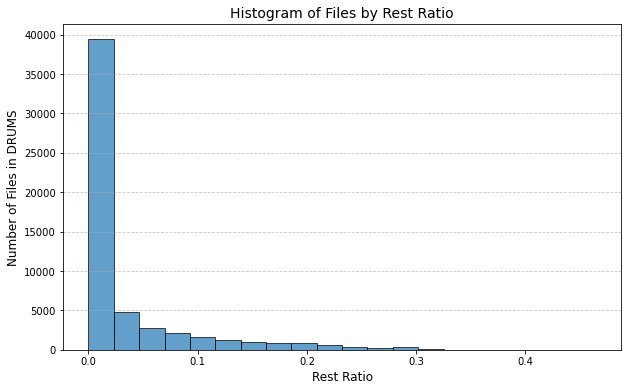

Mean Rest Ratio: 0.0339
Standard Deviation: 0.0617
Outlier Threshold (2σ): 0.1574
Files identified as outliers:
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Tool - Eulogy.gp3._161-176_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/NOFX - The Decline.gp3._385-400_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Spy Ladder - Sadness.gp3._65-68_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Oversoul - Death .gp4._17-32_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Helloween - The Departed (Sun Is Going Down) (2).gp4._49-64_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/mysteriousdarkness - The Chicken Warlord And The Bar Of Soap.gp4._1-16_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/NOFX - The Decline.gp3._513-528_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.

In [68]:
drum_chunks_path = '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums'

# list comprehension
drum_chunks = [os.path.join(drum_chunks_path, file) for file in os.listdir(drum_chunks_path)]
# SAME AS THIS:
# for file in os.listdir(path_output):
    # output.append(os.path.join(path_output, file))


# Compute rest ratios for all files
rest_ratios_drums = [compute_rest_ratio(file) for file in drum_chunks if compute_rest_ratio(file) is not None]

# Plot a histogram of rest ratios
plt.figure(figsize=(10, 6))
plt.hist(rest_ratios_drums, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Files by Rest Ratio", fontsize=14)
plt.xlabel("Rest Ratio", fontsize=12)
plt.ylabel("Number of Files in DRUMS", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Identify outliers using mean and standard deviation
import numpy as np
mean_ratio = np.mean(rest_ratios_drums)
std_ratio = np.std(rest_ratios_drums)
threshold = mean_ratio + 2 * std_ratio

print(f"Mean Rest Ratio: {mean_ratio:.4f}")
print(f"Standard Deviation: {std_ratio:.4f}")
print(f"Outlier Threshold (2σ): {threshold:.4f}")

# Filter files that are outliers
outliers = [file for file, ratio in zip(drum_chunks, rest_ratios_drums) if ratio > threshold]

print("Files identified as outliers:")
for outlier in outliers:
    print(outlier)


In [70]:
# Define the threshold for high rest ratio
rest_threshold = 0.3

# Generate the list of files with more than 30% rests
drum_rest_files = [file for file, ratio in zip(drum_chunks, rest_ratios_drums) if ratio >= rest_threshold]

print("Files with more than 30% rest tokens:")
print('{}/{}'.format(len(drum_rest_files), len(drum_chunks)))
print('{:.2f}%'.format(len(drum_rest_files)/len(drum_chunks)*100))

Files with more than 30% rest tokens:
243/56711
0.43%


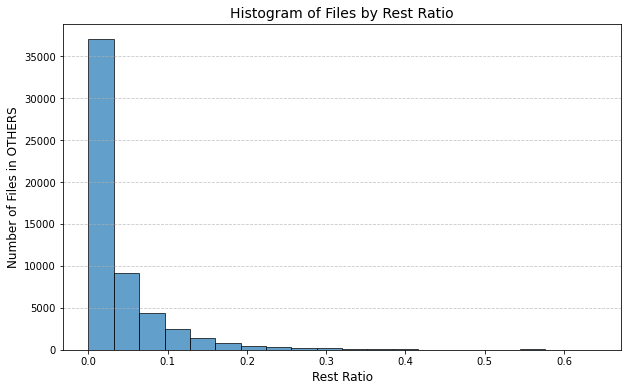

Mean Rest Ratio: 0.0377
Standard Deviation: 0.0620
Outlier Threshold (2σ): 0.1618
Files identified as outliers:
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/B'Z - ALONE.gp3._97-112_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/mysteriousdarkness - The Chicken Warlord And The Bar Of Soap.gp4._1-16_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/NOFX - The Decline.gp3._513-528_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/Beck - Devil's Haircut.gp3._65-80_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/Deep Purple - Burn.gp3._209-224_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/Symphony X - Wicked (2).gp3._65-80_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b/Led Zeppelin - Darlene.gp4._145-160_.tokens.txt
/Users/pedro/Desktop/DadaGP-v1.1/dat

In [71]:
others_chunks_path = '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b'

# list comprehension
others_chunks = [os.path.join(others_chunks_path, file) for file in os.listdir(others_chunks_path)]
# SAME AS THIS:
# for file in os.listdir(path_output):
    # output.append(os.path.join(path_output, file))


# Compute rest ratios for all files
rest_ratios_others = [compute_rest_ratio(file) for file in others_chunks if compute_rest_ratio(file) is not None]

# Plot a histogram of rest ratios
plt.figure(figsize=(10, 6))
plt.hist(rest_ratios_others, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Files by Rest Ratio", fontsize=14)
plt.xlabel("Rest Ratio", fontsize=12)
plt.ylabel("Number of Files in OTHERS", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Identify outliers using mean and standard deviation
import numpy as np
mean_ratio = np.mean(rest_ratios_others)
std_ratio = np.std(rest_ratios_others)
threshold = mean_ratio + 2 * std_ratio

print(f"Mean Rest Ratio: {mean_ratio:.4f}")
print(f"Standard Deviation: {std_ratio:.4f}")
print(f"Outlier Threshold (2σ): {threshold:.4f}")

# Filter files that are outliers
outliers = [file for file, ratio in zip(others_chunks, rest_ratios_others) if ratio > threshold]

print("Files identified as outliers:")
for outlier in outliers:
    print(outlier)


In [72]:
# Define the threshold for high rest ratio
rest_threshold = 0.3

# Generate the list of files with more than 30% rests
others_rest_files = [file for file, ratio in zip(others_chunks, rest_ratios_others) if ratio >= rest_threshold]

print("Files with more than 30% rest tokens:")
print('{}/{}'.format(len(others_rest_files), len(others_chunks)))
print('{:.2f}%'.format(len(others_rest_files)/len(others_chunks)*100))

Files with more than 30% rest tokens:
534/56711
0.94%


In [76]:
drum_rest_files

['/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Led Zeppelin - Bring It On Home.gp3._33-48_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Bon Jovi - Livin On A Prayer.gp4._49-64_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Avantasia - Farewell.gp3._97-112_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Metallica - Am I Evil.gp3._113-128_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Metallica - Of Wolf And Man (3).gp3._1-16_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Rossi, Vasco - Albachiara.gp4._1-16_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Faulty (The) - Take Everything Back.gp4._33-48_.tokens.txt',
 '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Metallica - Am I Evil.gp3._241-256_.tokens.txt',
 

In [81]:
len(drum_rest_files) + len(others_rest_files)
# len(others_rest_files)

777

In [83]:
# get total number  
total_rest_files = drum_rest_files + others_rest_files

['/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Led Zeppelin - Bring It On Home.gp3._33-48_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Bon Jovi - Livin On A Prayer.gp4._49-64_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Avantasia - Farewell.gp3._97-112_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Metallica - Am I Evil.gp3._113-128_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Metallica - Of Wolf And Man (3).gp3._1-16_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Rossi, Vasco - Albachiara.gp4._1-16_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Faulty (The) - Take Everything Back.gp4._33-48_.tokens.txt', '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums/Metallica - Am I Evil.gp3._241-256_.tokens.txt', '/Users/

In [89]:
# Getting rid of poor examples
# An example is considered poor if:
# 1) it is contained in total_rest_files (i.e. has more than 30% of rests)
# 2) does not contain exactly 16 measures

import os
import shutil


# Paths
input_directory = "/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_drums"  # Directory with .txt files
output_directory = "/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/filtered_drums"  # Directory for valid files
os.makedirs(output_directory, exist_ok=True)  # Ensure output directory exists

poor_rest_files = total_rest_files

# Define a function to count measures
def count_measures(file_path, search_string="new_measure"):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Count occurrences of "new_measure"
        measure_count = sum(line.count(search_string) for line in lines)
        return measure_count
    except Exception as e:
        print(f"Error analyzing file {file_path}: {e}")
        return None

# Iterate over all .txt files in the directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".txt"):
        file_path = os.path.join(input_directory, file_name)
        
        # Skip files already identified as poor based on rest ratio
        if file_name in poor_rest_files:
            print(f"Skipped (poor rest ratio): {file_name}")
            continue
        
        # Analyze measure count
        measure_count = count_measures(file_path)
        
        # Check if the file is valid (exactly 16 measures)
        if measure_count == 16:
            # File is valid; copy it to the output directory
            destination_path = os.path.join(output_directory, file_name)
            shutil.copy(file_path, destination_path)
            print(f"Copied: {file_name}")
        else:
            print(f"Skipped (invalid measure count): {file_name}")


Copied: Piersi - Caluj Mnie (3).gp3._113-128_.tokens.txt
Copied: Middleton, Danial - Abrasion.gp3._33-48_.tokens.txt
Copied: Horcas - Argentina, Tus Hijos.gp3._1-16_.tokens.txt
Copied: Satyricon - Hvite Krists Dod.gp4._209-224_.tokens.txt
Copied: ACDC - Dirty Deeds Done Dirt Cheap.gp3._81-96_.tokens.txt
Copied: High And Mighty Color - Ichirin No Hana.gp4._1-16_.tokens.txt
Copied: In Flames - Lunar Strain.gp3._129-144_.tokens.txt
Copied: Tool - Eulogy.gp3._161-176_.tokens.txt
Copied: In Flames - December Flower (2).gp4._49-64_.tokens.txt
Copied: Papa Roach - Not Listening (2).gp4._1-16_.tokens.txt
Copied: Edguy - Deadmaker.gp3._113-128_.tokens.txt
Copied: Liquid Tension Experiment - Another Dimension (2).gp4._17-32_.tokens.txt
Copied: NOFX - The Decline.gp3._385-400_.tokens.txt
Copied: Heavy Competition 11 - The Fallen Of The Ideas.gp3._97-112_.tokens.txt
Copied: Black Raven - Just With You.gp4._65-80_.tokens.txt
Skipped (invalid measure count): Stone Temple Pilots - Interstate Love Son

In [90]:
len(os.listdir(output_directory))

49572

In [91]:
# Getting rid of poor examples
# An example is considered poor if:
# 1) it is contained in total_rest_files (i.e. has more than 30% of rests)
# 2) does not contain exactly 16 measures

import os
import shutil

# Paths
input_directory = "/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/txts_16_dg-dg-b"  # Directory with .txt files
output_directory = "/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/filtered_dg-dg-b"  # Directory for valid files
os.makedirs(output_directory, exist_ok=True)  # Ensure output directory exists

poor_rest_files = total_rest_files

# Define a function to count measures
def count_measures(file_path, search_string="new_measure"):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Count occurrences of "new_measure"
        measure_count = sum(line.count(search_string) for line in lines)
        return measure_count
    except Exception as e:
        print(f"Error analyzing file {file_path}: {e}")
        return None

# Iterate over all .txt files in the directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".txt"):
        file_path = os.path.join(input_directory, file_name)
        
        # Skip files already identified as poor based on rest ratio
        if file_name in poor_rest_files:
            print(f"Skipped (poor rest ratio): {file_name}")
            continue
        
        # Analyze measure count
        measure_count = count_measures(file_path)
        
        # Check if the file is valid (exactly 16 measures)
        if measure_count == 16:
            # File is valid; copy it to the output directory
            destination_path = os.path.join(output_directory, file_name)
            shutil.copy(file_path, destination_path)
            print(f"Copied: {file_name}")
        else:
            print(f"Skipped (invalid measure count): {file_name}")


Copied: Piersi - Caluj Mnie (3).gp3._113-128_.tokens.txt
Copied: Middleton, Danial - Abrasion.gp3._33-48_.tokens.txt
Copied: Horcas - Argentina, Tus Hijos.gp3._1-16_.tokens.txt
Copied: Satyricon - Hvite Krists Dod.gp4._209-224_.tokens.txt
Copied: ACDC - Dirty Deeds Done Dirt Cheap.gp3._81-96_.tokens.txt
Copied: High And Mighty Color - Ichirin No Hana.gp4._1-16_.tokens.txt
Copied: In Flames - Lunar Strain.gp3._129-144_.tokens.txt
Copied: Tool - Eulogy.gp3._161-176_.tokens.txt
Copied: In Flames - December Flower (2).gp4._49-64_.tokens.txt
Copied: Papa Roach - Not Listening (2).gp4._1-16_.tokens.txt
Copied: Edguy - Deadmaker.gp3._113-128_.tokens.txt
Copied: Liquid Tension Experiment - Another Dimension (2).gp4._17-32_.tokens.txt
Copied: NOFX - The Decline.gp3._385-400_.tokens.txt
Copied: Heavy Competition 11 - The Fallen Of The Ideas.gp3._97-112_.tokens.txt
Copied: Black Raven - Just With You.gp4._65-80_.tokens.txt
Skipped (invalid measure count): Stone Temple Pilots - Interstate Love Son

In [96]:
len(os.listdir(path_final_drums))

49572

In [100]:
# sanity check
path_final_drums = '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/filtered_drums'
path_final_others = '/Users/pedro/Desktop/DadaGP-v1.1/data-prep-acc-gen/data/filtered_dg-dg-b'



assert len(os.listdir(path_final_drums)) == len(os.listdir(path_final_others))

print('Finally, the length of the dataset with <30% rest occurence, and only 16 measures is:\n')
print(len(os.listdir(path_final_drums)))

Finally, the length of the dataset with <30% rest occurence, and only 16 measures is:

49572
